In [91]:
import json 
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import re
from fractions import Fraction
from unidecode import unidecode
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from collections import Counter

In [2]:
def parse_ingredient(ingredient):   
    pattern = r'([\d½⅓⅔¼¾]+)\s*(г|кг|мл|л|ст\.\s*л\.|ч\.\s*л\.)?\s+(.*)'
    match = re.match(pattern, ingredient,  flags=re.UNICODE)
    
    if match:
        quantity_str = unidecode(match.group(1))  # Convert Unicode characters to ASCII
        quantity = float(sum(Fraction(s) for s in quantity_str.split()))
        
        unit = match.group(2)
        if not unit:
            unit = "штука"  # Default unit if not specified
        
        if unit in ("г", "мл"):
            quantity /= 1000
            if unit == "г":
                unit = "кг"
            elif unit == "мл":
                unit = "л"
        unit = unit.replace(" ", "")
        
        return {
            'інгредієнт': match.group(3).strip(),
            'одиниця вимірювання': unit,
            'кількість': round(quantity, 2),
            'raw': ingredient
        }
    else:
        print(f"Unable to parse ingredient: {ingredient}")
        return {'raw': ingredient}

In [3]:
def store_page_html(page_url, output_path):
    page = requests.get(page_url)
    with open(output_path, 'w') as file: 
        file.write(page.text)
    return page.text

In [11]:
# test_url = 'https://klopotenko.com/smazheni-shulyky-z-makom-ta-medom-vid-yevgena-klopotenka/'
# test_path = 'html_pages/test.html'
# text = store_page_html(test_url, test_path)

In [33]:
def parse_page(page_text, page_url):
    def _text_extract(item):
        if item is not None:
            return item.get_text()
    # page = requests.get(page_url)
    soup = BeautifulSoup(page_text, "html.parser")
    title = _text_extract(soup.find(class_='item-title'))
    cuisine = _text_extract(soup.find(class_='recipe-cuisine'))
    ingredient_list = soup.find(class_='ingredient-list')
    if ingredient_list is not None:
        ingredient_list = ingredient_list.find_all('div', class_='checkbox checkbox-primary')
        try:
            ingredients = []
            for box in ingredient_list:
                if box.find('div') is None:
                    ingredients.append(parse_ingredient(box.get_text().strip()))
        except Exception as e:
            print(f'Couldn\'t extract ingridients. {e}')
            ingredients = []
    

    structure = dict()
    structure['Рецепт'] = title
    structure['Кухня'] = cuisine
    header = soup.find('div', class_='item-feature')
    if header is not None:

        for block in header.find_all('li'):
            key = _text_extract(block.find('div', class_='feature-title'))
            value = _text_extract(block.find('div', class_='feature-sub-title'))
            if key is not None:
                structure[key] = value
    
    structure['Інгредієнти'] = ingredients
    structure['Посилання'] = page_url
    return structure
    

In [20]:
def get_klopotenko_recipes():
    with open('klopotenko.html', 'r') as f:
        page = f.read()
    soup = BeautifulSoup(page, "html.parser")
    recipes = [h3.find("a")['href'] for h3 in soup.find('div', id='ajax-posts-recipes').find_all("h3")]
    return recipes


In [182]:
# parse_page(
#     'https://klopotenko.com/pisnyj-variant-golubczi-z-tertoyi-kartopli-vid-yevgena-klopotenka/'
# )

In [21]:
recipes = get_klopotenko_recipes()

In [22]:
# htmls = []
# recipes = get_klopotenko_recipes()
# for i in tqdm(range(len(recipes))):
#     recipe_url = recipes[i]
#     path = f'html_pages/{i}.html'
#     htmls.append(
#         {
#             "url": recipe_url,
#             "page": store_page_html(recipe_url, path)
#         }

#     )

100%|█████████████████████████████████████████| 200/200 [02:21<00:00,  1.42it/s]


In [40]:
data = []
for item in tqdm(htmls):
    data.append(parse_page(item['page'], item['url']))

  5%|██                                        | 10/200 [00:00<00:06, 29.37it/s]

Unable to parse ingredient: 0,5 пучка петрушки
Unable to parse ingredient: сік чверті лимона
Unable to parse ingredient: 1,5 л води
Unable to parse ingredient: 1,5 л води
Unable to parse ingredient: 100-150 г консервованої кукурудзи
Unable to parse ingredient: 1-2 зубчики часнику


 12%|█████▎                                    | 25/200 [00:00<00:04, 39.84it/s]

Unable to parse ingredient: 2-3 кульки пломбірного морозива
Unable to parse ingredient: дрібка морської солі
Unable to parse ingredient: 1,5 кг свинини


 18%|███████▎                                  | 35/200 [00:00<00:04, 39.96it/s]

Unable to parse ingredient: 2-3 ст. л рослинної олії
Unable to parse ingredient: сіль до смаку
Unable to parse ingredient: перець до смаку
Unable to parse ingredient: 2-3 ст. л. рослинної олії
Unable to parse ingredient: масло чи мед для змащування
Unable to parse ingredient: базилік для подачі


 25%|██████████▌                               | 50/200 [00:01<00:03, 38.16it/s]

Unable to parse ingredient: дрібка солі
Unable to parse ingredient: кілька крапель ванільного екстракту
Unable to parse ingredient: 100-150 г цукру
Unable to parse ingredient: 150-200 г цукрової пудри
Unable to parse ingredient: 150-200 г цукрової пудри
Unable to parse ingredient: дрібка солі
Unable to parse ingredient: кілька крапель ванільного екстракту
Unable to parse ingredient: Лимон для подачі (за бажанням)
Unable to parse ingredient: Сіль і перець


 32%|█████████████▋                            | 65/200 [00:01<00:03, 37.23it/s]

Unable to parse ingredient: 1,1 кг гарбуза (850 г очищеного)
Unable to parse ingredient: цедра 2 апельсинів
Unable to parse ingredient: сметана чи мед для подачі
Unable to parse ingredient: 500-600 г індички
Unable to parse ingredient: сік половини лимона (за бажанням)


 38%|███████████████▊                          | 75/200 [00:02<00:03, 37.29it/s]

Unable to parse ingredient: 1,5 ст.л. сухарів
Unable to parse ingredient: 1/2 ч.л.
Unable to parse ingredient: сік та цедра 1 лимона


 42%|█████████████████▊                        | 85/200 [00:02<00:03, 37.34it/s]

Unable to parse ingredient: дрібка солі
Unable to parse ingredient: 1-2 ст. л. рисового борошна для панірування
Unable to parse ingredient: 3-4 ст. л. рослинної олії для смаження
Unable to parse ingredient: 1,5 ч. л. розпушувача


 48%|███████████████████▉                      | 95/200 [00:02<00:02, 36.80it/s]

Unable to parse ingredient: дрібка солі
Unable to parse ingredient: 1/2 ч.л. чорного меленого перцю
Unable to parse ingredient: дрібка солі
Unable to parse ingredient: 50-70 г вершкового масла для подачі
Unable to parse ingredient: дрібка солі
Unable to parse ingredient: сіль та перець до смаку


 52%|█████████████████████▎                   | 104/200 [00:02<00:02, 37.10it/s]

Unable to parse ingredient: дрібка солі
Unable to parse ingredient: сіль до смаку
Unable to parse ingredient: сіль та перець до смаку
Unable to parse ingredient: дрібка паприки
Unable to parse ingredient: зелень (для подачі за бажанням)
Unable to parse ingredient: 300-350 мл фільтр кави
Unable to parse ingredient: 2-3 г сушеної ромашки
Unable to parse ingredient: сіль та перець до смаку
Unable to parse ingredient: за бажанням шкварки


 58%|███████████████████████▉                 | 117/200 [00:03<00:02, 36.19it/s]

Unable to parse ingredient: 20-24 апельсини
Unable to parse ingredient: соус ранч і овочі для подачі
Unable to parse ingredient: 1,5 - 2 л води для відварювання квасолі
Unable to parse ingredient: перець до смаку
Unable to parse ingredient: дольки 1 лимона (для подачі)
Unable to parse ingredient: перець до смаку
Unable to parse ingredient: 1/2 ч.л. соди


 64%|██████████████████████████▏              | 128/200 [00:03<00:01, 37.30it/s]

Unable to parse ingredient: 1/3 ч.л. солі
Unable to parse ingredient: 1/4 ч.л. солі
Unable to parse ingredient: 2-3 ст. л. соняшникової олії
Unable to parse ingredient: 1-2 ст. л. бальзамічного оцту
Unable to parse ingredient: за смаком сіль та перець
Unable to parse ingredient: 750-800 г борошна + для підпилу
Unable to parse ingredient: дрібка солі
Unable to parse ingredient: 6-7 см свіжого імбиру або ½ ч.л. сушеного
Unable to parse ingredient: вершкове масло 50 г
Unable to parse ingredient: пучок петрушки
Unable to parse ingredient: сіль до смаку


 69%|████████████████████████████▎            | 138/200 [00:03<00:01, 37.96it/s]

Unable to parse ingredient: дрібка солі
Unable to parse ingredient: кілька крапель Табаско чи Гострого соусу
Unable to parse ingredient: чорний або білий мелений перець до смаку
Unable to parse ingredient: кілька крапель табаско чи гострого соусу
Unable to parse ingredient: 3-4 листки салату
Unable to parse ingredient: 10-15 г сушеної бузини
Unable to parse ingredient: цедра 1 лимону
Unable to parse ingredient: сіль до смаку
Unable to parse ingredient: перець до смаку
Unable to parse ingredient: 0,5 г меленого мускатного горіха
Unable to parse ingredient: 1\2 червоної цибулини
Unable to parse ingredient: 1\4 перцю чилі
Unable to parse ingredient: 1-2 ст. л. оливкової олії
Unable to parse ingredient: сік половини лимона
Unable to parse ingredient: 1,2 кг свинини (задня частина або ошийок)
Unable to parse ingredient: сіль до смаку
Unable to parse ingredient: 2,5 л води
Unable to parse ingredient: 4-5 лаврових листів
Unable to parse ingredient: 5-6 горошин чорного перцю
Unable to parse in

 74%|██████████████████████████████▎          | 148/200 [00:03<00:01, 38.20it/s]

Unable to parse ingredient: сіль і перець до смаку
Unable to parse ingredient: сіль до смаку
Unable to parse ingredient: перець до смаку
Unable to parse ingredient: 4-5 ст. л.рослинної олії
Unable to parse ingredient: 2,5 - 3 л води
Unable to parse ingredient: дрібка солі
Unable to parse ingredient: мікрогрін до смаку
Unable to parse ingredient: сік половини лимона
Unable to parse ingredient: узвар для подачі
Unable to parse ingredient: 250-300 г пшениці
Unable to parse ingredient: 2-3 ст. л. меду
Unable to parse ingredient: цукрова пудра для подачі


 78%|████████████████████████████████▏        | 157/200 [00:04<00:01, 37.95it/s]

Unable to parse ingredient: 1-2 ст. л. коньяку в сухофрукти
Unable to parse ingredient: 25-30 г дріжджів («Духмяна хата»)
Unable to parse ingredient: до смаку апельсинова цедра
Unable to parse ingredient: 2-3 ст. л. цукрової пудри
Unable to parse ingredient: цедра 1 лимона
Unable to parse ingredient: цедра 1 апельсина


 86%|███████████████████████████████████      | 171/200 [00:04<00:00, 37.40it/s]

Unable to parse ingredient: сіль до смаку
Unable to parse ingredient: 75-100 г цукру (залежить від того, наскільки солодкі пампушки ви хочете)
Unable to parse ingredient: цедра 1 апельсина
Unable to parse ingredient: цукрова пудра до смаку
Unable to parse ingredient: багет
Unable to parse ingredient: перець до смаку
Unable to parse ingredient: сіль та перець до смаку
Unable to parse ingredient: дрібка солі


 94%|██████████████████████████████████████▎  | 187/200 [00:04<00:00, 41.35it/s]

Unable to parse ingredient: 3-4 листки салату
Unable to parse ingredient: сік ½ лимона
Unable to parse ingredient: цедра 1 апельсина
Unable to parse ingredient: 2-3 гілочки кропу (за бажанням)


 98%|████████████████████████████████████████▍| 197/200 [00:05<00:00, 37.18it/s]

Unable to parse ingredient: сіль до смаку
Unable to parse ingredient: цедра і фреш ½ лимона чи 1 лайма
Unable to parse ingredient: сік половини лимона
Unable to parse ingredient: хліб або сухарі з білого хліба для подачі


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 37.57it/s]

Unable to parse ingredient: дрібка солі


In [41]:
# with open('klopotenko.html', 'r') as f:
#     page = f.read()
# soup = BeautifulSoup(page, "html.parser")


In [42]:
# data = []
# recipes = get_klopotenko_recipes()
# for recipe_url in tqdm(recipes):
#     data.append(parse_page(recipe_url))

In [43]:
# with open('klopotenko_recipies_raw.json', 'w') as f:
#     for line in data:
#         f.write(json.dumps(line, ensure_ascii=False) + '\n')
    

In [4]:
data = []
with open('klopotenko_recipies_raw.json', 'r') as f:
    for line in f.readlines():
        data.append(json.loads(line.strip()))
    

In [5]:
recipes_df = pd.DataFrame(data)

In [6]:
recipes_df

Рецепт        Кухня  \
0    Нова ідея класичного салату. Салат з пекінсько...  Європейська   
1    Салат з пекінської капусти та сухариків від Єв...   Українська   
2    У вершковому соусі. Равіолі з сиром від Євгена...   Італійська   
3    Гарбузовий торт зі сметанним кремом від Євгена...   Українська   
4    Сирники з яблуками та корицею за рецептом Євге...   Українська   
..                                                 ...          ...   
195  Легкий і корисний. Салат з буряком і фетою від...  Європейська   
196  Ніжний паштет з лівером та коньяком від Євгена...  Європейська   
197  Рокот крумплі по-закарпатськи: запіканка з кар...  Європейська   
198  Шоколадні пряники на кефірі від Євгена Клопотенка  Європейська   
199  Цвітна капуста в клярі в духовці від Євгена Кл...  Європейська   

                                  Приготування Порції Складність  \
0                                    10 хвилин      2      Легко   
1                                        18 хв      2      Легко   
2                                    50 хвилин      2    Помірно   
3       2 год 8 хв+2 год на підготовку сметани      5    Помірно   
4                                        40 хв      2      Легко   
..                                         ...    ...        ...   
195                         1 година 40 хвилин      2      Легко   
196  1 година 10 хвилин + 30 хв на охолодження      6      Легко   
197                         1 година 20 хвилин      6    Помірно   
198                                  50 хвилин      4      Легко   
199                                  35 хвилин      2      Легко   

                                           Інгредієнти  \
0    [{'інгредієнт': 'пекінської капусту', 'одиниця...   
1    [{'інгредієнт': 'пекінської капусти (половина ...   
2    [{'інгредієнт': 'борошна', 'одиниця вимірюванн...   
3    [{'інгредієнт': 'очищеного гарбуза (300 г неоч...   
4    [{'інгредієнт': 'кисломолочного сиру', 'одиниц...   
..                                                 ...   
195  [{'інгредієнт': 'середніх буряки', 'одиниця ви...   
196  [{'інгредієнт': 'курячої печінки', 'одиниця ви...   
197  [{'інгредієнт': 'картоплі', 'одиниця вимірюван...   
198  [{'інгредієнт': 'кефіру', 'одиниця вимірювання...   
199  [{'інгредієнт': 'капусти', 'одиниця вимірюванн...   

                                             Посилання  
0    https://klopotenko.com/nova-ideya-klasychnogo-...  
1    https://klopotenko.com/salat-z-pekinskoyi-kapu...  
2    https://klopotenko.com/u-vershkovomu-sousi-rav...  
3    https://klopotenko.com/%D0%93%D0%B0%D1%80%D0%B...  
4    https://klopotenko.com/syrnyky-z-yablukamy-ta-...  
..                                                 ...  
195  https://klopotenko.com/legkyj-i-korysnyj-salat...  
196  https://klopotenko.com/nizhnyj-pashtet-z-liver...  
197  https://klopotenko.com/rokot-krumpli-po-zakarp...  
198  https://klopotenko.com/shokoladni-pryanyky-na-...  
199  https://klopotenko.com/czvitna-kapusta-v-klyar...  

[200 rows x 7 columns]

In [7]:
missing_values = recipes_df.isnull().sum()

In [8]:
missing_values

Рецепт          0
Кухня           2
Приготування    0
Порції          0
Складність      0
Інгредієнти     0
Посилання       0
dtype: int64

In [9]:
missing_cuisine_records = recipes_df[recipes_df['Кухня'].isnull()]

# Display the records where 'Кухня' column has missing values
print("Records with missing values for 'Кухня':")
print(missing_cuisine_records)

Records with missing values for 'Кухня':
                                               Рецепт Кухня  \
27  Риба моєї мрії – домашній рецепт маринованої с...  None   
92  Проста випічка до чаю. Пісочне печиво від Євге...  None   

                              Приготування Порції Складність  \
27  10 хвилин (+24 години для маринування)      6      Легко   
92                              1 год 5 хв      2      Легко   

                                          Інгредієнти  \
27  [{'інгредієнт': 'заморожені скумбрії', 'одиниц...   
92  [{'інгредієнт': 'вершкового масла кімнатної те...   

                                            Посилання  
27  https://klopotenko.com/ryba-moyeyi-mriyi-domas...  
92  https://klopotenko.com/prosta-vypichka-do-chay...  


In [10]:
recipes_df['Кухня'].unique()

array(['Європейська', 'Українська', 'Італійська', 'Європейська, ',
       'Автентична українська кухня, ', 'Американська',
       'Автентична українська кухня', 'Арабська', None, 'Східна',
       'Кримськотатарська', 'Українська, ', 'Мексиканська', 'Японська',
       'Французька', 'Американська, '], dtype=object)

In [11]:
pd.set_option('display.max_colwidth', None)

In [12]:
recipes_df[recipes_df['Кухня'] == 'Автентична українська кухня']

Рецепт  \
16       Смажені шулики з маком та медом від Євгена Клопотенка   
32  Вареники з картоплею на парі за рецептом Євгена Клопотенка   

                          Кухня                   Приготування Порції  \
16  Автентична українська кухня  30 хв+1-2 год для настоювання      2   
32  Автентична українська кухня                    1 год 20 хв      4   

   Складність  \
16      Легко   
32    Помірно   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Інгредієнти  \
16                                                                                                                                                                                                                                                                                                                                                                    [{'інгредієнт': 'пшеничного борошна', 'одиниця вимірювання': 'кг', 'кількість': 0.16, 'raw': '160 г пшеничного борошна'}, {'інгредієнт': 'теплого кефіру', 'одиниця вимірювання': 'ст.л.', 'кількість': 7.0, 'raw': '7 ст. л. теплого кефіру'}, {'інгредієнт': 'солі', 'одиниця вимірювання': 'ч.л.', 'кількість': 0.5, 'raw': '½ ч. л. солі'}, {'інгредієнт': 'розпушувача', 'одиниця вимірювання': 'ч.л.', 'кількість': 1.0, 'raw': '1 ч. л. розпушувача'}, {'інгредієнт': 'маку', 'одиниця вимірювання': 'кг', 'кількість': 0.15, 'raw': '150 г маку'}, {'інгредієнт': 'меду', 'одиниця вимірювання': 'ст.л.', 'кількість': 4.0, 'raw': '4 ст. л. меду'}, {'інгредієнт': 'кип'яченої води', 'одиниця вимірювання': 'л', 'кількість': 0.25, 'raw': '250 мл кип'яченої води'}]   
32  [{'інгредієнт': 'пшеничного борошна', 'одиниця вимірювання': 'кг', 'кількість': 0.4, 'raw': '400 г пшеничного борошна'}, {'інгредієнт': 'солі', 'одиниця вимірювання': 'ч.л.', 'кількість': 0.5, 'raw': '½ ч. л. солі'}, {'інгредієнт': 'цукру', 'одиниця вимірювання': 'ч.л.', 'кількість': 0.5, 'raw': '½ ч. л. цукру'}, {'інгредієнт': 'соди', 'одиниця вимірювання': 'ч.л.', 'кількість': 0.5, 'raw': '½ ч. л. соди'}, {'інгредієнт': 'кефіру', 'одиниця вимірювання': 'л', 'кількість': 0.3, 'raw': '300 мл кефіру'}, {'інгредієнт': 'борошна для підпилу', 'одиниця вимірювання': 'ст.л.', 'кількість': 1.0, 'raw': '1 ст. л. борошна для підпилу'}, {'інгредієнт': 'картоплі', 'одиниця вимірювання': 'кг', 'кількість': 0.5, 'raw': '500 г картоплі'}, {'інгредієнт': 'солі', 'одиниця вимірювання': 'ч.л.', 'кількість': 0.5, 'raw': '½ ч. л. солі'}, {'інгредієнт': 'цибулина', 'одиниця вимірювання': 'штука', 'кількість': 1.0, 'raw': '1 цибулина'}, {'raw': '2-3 ст. л. рослинної олії'}, {'інгредієнт': 'вершкового масла для подачі', 'одиниця вимірювання': 'кг', 'кількість': 0.05, 'raw': '50 г вершкового масла для подачі'}]   

                                                                                 Посилання  
16       https://klopotenko.com/smazheni-shulyky-z-makom-ta-medom-vid-yevgena-klopotenka/   
32  https://klopotenko.com/varenyky-z-kartopleyu-na-pari-za

In [13]:
recipes_df['Кухня'] = recipes_df['Кухня'].str.replace(', ', '')

# Display the updated DataFrame
print(recipes_df['Кухня'])

0      Європейська
1       Українська
2       Італійська
3       Українська
4       Українська
          ...     
195    Європейська
196    Європейська
197    Європейська
198    Європейська
199    Європейська
Name: Кухня, Length: 200, dtype: object


In [14]:
recipes_df['Кухня'].unique()

array(['Європейська', 'Українська', 'Італійська',
       'Автентична українська кухня', 'Американська', 'Арабська', None,
       'Східна', 'Кримськотатарська', 'Мексиканська', 'Японська',
       'Французька'], dtype=object)

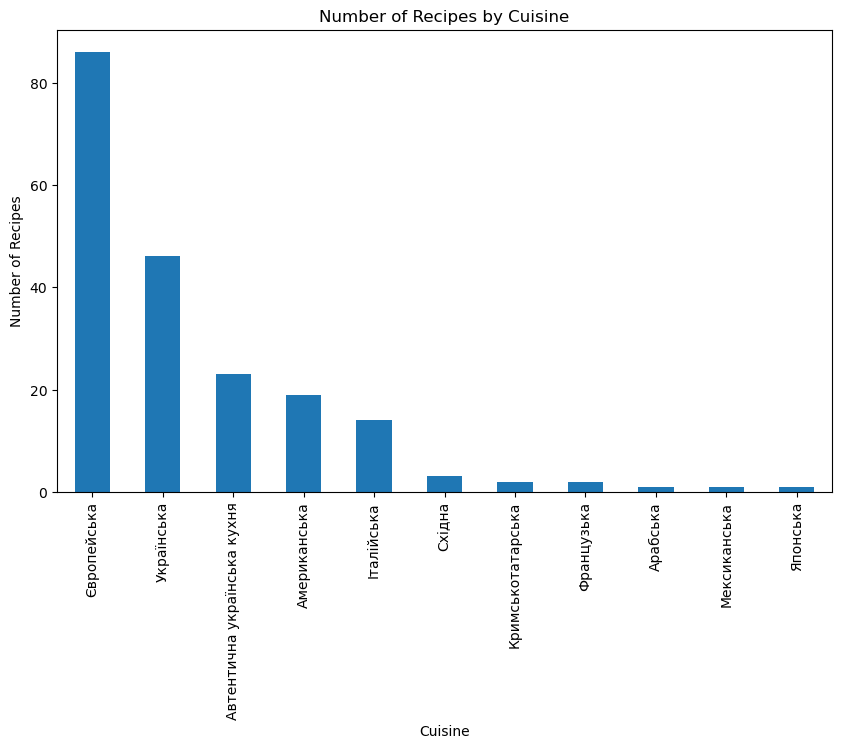

In [15]:
# Count the occurrences of each cuisine type
cuisine_counts = recipes_df['Кухня'].value_counts()

# Visualize the counts using a bar plot
plt.figure(figsize=(10, 6))
cuisine_counts.plot(kind='bar')
plt.title('Number of Recipes by Cuisine')
plt.xlabel('Cuisine')
plt.ylabel('Number of Recipes')
plt.xticks(rotation=90)
plt.show()

In [16]:
recipes_df['Приготування'].unique()

array(['10 хвилин', '18 хв', '50 хвилин',
       '2 год 8 хв+2 год на підготовку сметани', '40 хв', '1 год 20 хв',
       '1 год 45 хв', '35 хвилин', '1 год+1 год 20 хв на підняття тіста',
       '1 год 5 хв', '20 хв', '16 хв + 1 год', '1 год',
       '1 год 5 хв+35 хв на охолодження', '1 год 40 хв',
       '30 хв+1-2 год для настоювання', '40 хв+1-2 год на охолодження',
       '8 хв', '1 година', '1 год 35 хв', '2 год 30 хв',
       '10 хв +10-12 год для підготовки сметани', '1 год 10 хв',
       '1 год + 2 год настоювання',
       '10 хвилин (+24 години для маринування)', '1 год 15 хв',
       '1 год 50 хв', '55 хвилин', '40 хвилин', '45 хвилин', '15',
       '25 хвилин', '35 хв', '1 год 20 хв+30 хв на охолодження капкейків',
       '15 хв', '1 год +30 хв на охолодження', '7 хвилин', '45 хв',
       '1 година 10 хвилин', '6 год 50 хв', '30 хв',
       '1 год 10 хв + 2 год', '2 год 10 хв', '30 хвилин', '1 год 25 хв',
       '2 год', '1 год 45 хв+8 год для просочування',
       '1 год 

In [17]:
pd.set_option('display.max_rows', None)

In [18]:
mapping = {
    "10 хвилин": 10,
    "18 хв": 18,
    "50 хвилин": 50,
    "2 год 8 хв+2 год на підготовку сметани": 248,
    "40 хв": 40,
    "1 год 20 хв": 80,
    "1 год 45 хв": 105,
    "35 хвилин": 35,
    "1 год+1 год 20 хв на підняття тіста": 140,
    "1 год 5 хв": 65,
    "20 хв": 20,
    "16 хв + 1 год": 76,
    "1 год": 60,
    "1 год 5 хв+35 хв на охолодження": 100,
    "1 год 40 хв": 100,
    "30 хв+1-2 год для настоювання": 150,
    "40 хв+1-2 год на охолодження": 160,
    "8 хв": 8,
    "1 година": 60,
    "1 год 35 хв": 95,
    "2 год 30 хв": 150,
    "10 хв +10-12 год для підготовки сметани": 730,
    "1 год 10 хв": 70,
    "1 год + 2 год настоювання": 180,
    "10 хвилин (+24 години для маринування)": 1450,
    "1 год 15 хв": 75,
    "1 год 50 хв": 110,
    "55 хвилин": 55,
    "40 хвилин": 40,
    "45 хвилин": 45,
    "15": 15,
    "25 хвилин": 25,
    "35 хв": 35,
    "1 год 20 хв+30 хв на охолодження капкейків": 110,
    "15 хв": 15,
    "1 год +30 хв на охолодження": 90,
    "7 хвилин": 7,
    "45 хв": 45,
    "1 година 10 хвилин": 70,
    "6 год 50 хв": 410,
    "30 хв": 30,
    "1 год 10 хв + 2 год": 190,
    "2 год 10 хв": 130,
    "30 хвилин": 30,
    "1 год 25 хв": 85,
    "2 год": 120,
    "1 год 45 хв+8 год для просочування": 585,
    "1 год 30 хв + 4 год настоювання": 330,
    "1 год 35 хв + 4 год": 281,
    "45 хв+30 на остигання печива": 75,
    "45": 45,
    "1 год 10 хв + 1 год настоювання": 130,
    "1 год 30 хв + 18 год замочування": 1170,
    "2 год 15 хв + настоювання": 135,
    "3 години": 180,
    "55 хв+2 год на підсушування": 175,
    "2 години": 120,
    "2 години 50 хвилин": 170,
    "1 год 30 хв": 90,
    "1 година + 50 хвилин на приготування м'яса": 110,
    "1 година (+8 год замочування)": 540,
    "15 хвилин": 15,
    "1 год + 1,5 год на відварювання квасолі": 150,
    "30 хв + 6 год": 390,
    "6 годин 30 хвилин": 390,
    "55 хв": 55,
    "1 год 20 хвилин": 80,
    "1 година 40 хвилин": 100,
    "2 год 20 хвилин": 140,
    "60 хв.": 60,
    "50 хв": 50,
    "27 хв": 27,
    "10 хв": 10,
    "45 хв + 6 год на стабілізацію": 405,
    "40 хв. +4 год.": 280,
    "25 хв": 25,
    "17 хв": 17,
    "1 г 30 хв": 90,
    "1 г 45 хв": 105,
    "2 години 30 хвилин": 150,
    "4 г + 12 г на застигання": 960,
    "27 хвилин": 27,
    "1 г 35 хв": 95,
    "1 година 5 хвилин": 65,
    "3 години 20 хвилин": 200,
    "15 хвилин + 1,5 години на запікання буряка": 105,
    "30 хвилин+8 годин на просочування": 510,
    "35 хвилин+8 годин на маринування лосося": 515,
    "8 годин 15 хвилин": 495,
    "1 година 10 хвилин + 30 хв на охолодження": 100,
    "1 г 40 хв.": 100,
    "1 година 20 хвилин": 80,
    "1 година 25 хвилин": 85,
    "3 години 50 хвилин": 230,
    "20 хвилин": 20,
    "1 година 45 хвилин": 105,
    "2 години 20 хвилин": 140,
    "1 година 15 хвилин": 75,
    "2 години 45 хвилин": 165,
    "1 година 35 хвилин": 95,    
}


# # Create DataFrame
# recipes_df_1 = pd.DataFrame(data)

# Define a function to convert time strings to minutes
def convert_to_minutes(time_str):
    total_minutes = mapping.get(time_str)
    return total_minutes

# Apply the function to the 'Приготування' column
recipes_df['Приготування_1'] = recipes_df['Приготування'].apply(convert_to_minutes)

In [19]:
recipes_df[['Приготування_1', 'Приготування']]

Приготування_1                                Приготування
0                10                                   10 хвилин
1                18                                       18 хв
2                50                                   50 хвилин
3               248      2 год 8 хв+2 год на підготовку сметани
4                40                                       40 хв
5                80                                 1 год 20 хв
6               105                                 1 год 45 хв
7                35                                   35 хвилин
8               140         1 год+1 год 20 хв на підняття тіста
9                35                                   35 хвилин
10               65                                  1 год 5 хв
11               20                                       20 хв
12               76                               16 хв + 1 год
13               60                                       1 год
14              100             1 год 5 хв+35 хв на охолодження
15              100                                 1 год 40 хв
16              150               30 хв+1-2 год для настоювання
17              160                40 хв+1-2 год на охолодження
18                8                                        8 хв
19               60                                    1 година
20              105                                 1 год 45 хв
21               95                                 1 год 35 хв
22               60                                    1 година
23              150                                 2 год 30 хв
24              730     10 хв +10-12 год для підготовки сметани
25               70                                 1 год 10 хв
26              180                   1 год + 2 год настоювання
27             1450      10 хвилин (+24 години для маринування)
28               75                                 1 год 15 хв
29              110                                 1 год 50 хв
30               65                                  1 год 5 хв
31               70                                 1 год 10 хв
32               80                                 1 год 20 хв
33               55                                   55 хвилин
34               70                                 1 год 10 хв
35              100                                 1 год 40 хв
36               40                                   40 хвилин
37               50                                   50 хвилин
38               50                                   50 хвилин
39               45                                   45 хвилин
40               60                                    1 година
41               45                                   45 хвилин
42               15                                          15
43               25                                   25 хвилин
44               50                                   50 хвилин
45               35                                       35 хв
46               55                                   55 хвилин
47              110  1 год 20 хв+30 хв на охолодження капкейків
48               15                                       15 хв
49               90                 1 год +30 хв на охолодження
50               80                                 1 год 20 хв
51                7                                    7 хвилин
52               15                                       15 хв
53               70                                 1 год 10 хв
54               45                                       45 хв
55               70                          1 година 10 хвилин
56              410                                 6 год 50 хв
57               60                                    1 година
58               15                                       15 хв
59               35                                       35 хв
60               70                                 1 год 10 хв
61               45                  

In [20]:
recipes_df['Приготування'] = recipes_df['Приготування_1']
del recipes_df['Приготування_1']

In [21]:
recipes_df.columns

Index(['Рецепт', 'Кухня', 'Приготування', 'Порції', 'Складність',
       'Інгредієнти', 'Посилання'],
      dtype='object')

In [22]:
recipes_df.head()

Рецепт  \
0  Нова ідея класичного салату. Салат з пекінської капусти з огірками і помідорами   
1                    Салат з пекінської капусти та сухариків від Євгена Клопотенка   
2                        У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
3                        Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
4                      Сирники з яблуками та корицею за рецептом Євгена Клопотенка   

         Кухня  Приготування Порції Складність  \
0  Європейська            10      2      Легко   
1   Українська            18      2      Легко   
2   Італійська            50      2    Помірно   
3   Українська           248      5    Помірно   
4   Українська            40      2      Легко   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Інгредієнти  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       [{'інгредієнт': 'пекінської капусту', 'одиниця вимірювання': 'кг', 'кількість': 0.35, 'raw': '350 г пекінської капусту'}, {'інгредієнт': 'томати', 'одиниця вимірювання': 'штука', 'кількість': 2.0, 'raw': '2 томати'}, {'інгредієнт': 'огірок', 'одиниця вимірювання': 'штука', 'кількість': 1.0, 'raw': '1 огірок'}, {'інгредієнт': 'пучок кінзи', 'одиниця вимірювання': 'штука', 'кількість': 1.0, 'raw': '1 пучок кінзи'}, {'інгредієнт': 'ароматної олії', 'одиниця вимірювання': 'ст.л.', 'кількість': 3.0, 'raw': '3 ст.л. ароматної олії'}, {'інгредієнт': 'солі', 'одиниця вимірювання': 'ч.л.', 'кількість': 0.33, 'raw': '⅓ ч.л. солі'}]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       [{'інгредієнт': 'пекінської капусти (половина качана)', 'одиниця вимірювання': 'кг', 'кількість'

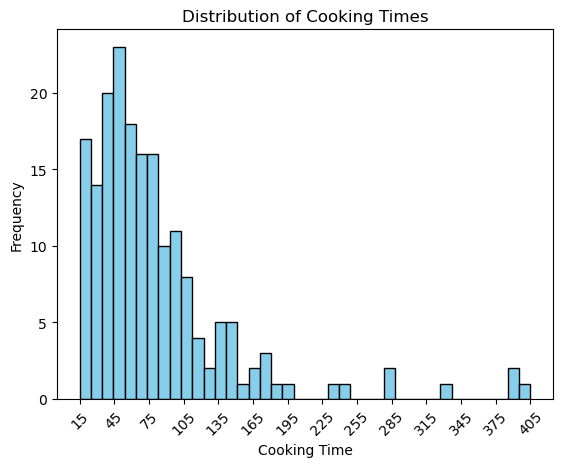

In [36]:
cooking_time = recipes_df['Приготування']

# Define a range for non-outliers (e.g., between the 5th and 95th percentiles)
q5 = cooking_time.quantile(0.05)
q95 = cooking_time.quantile(0.95)

# Filter the data to remove outliers
filtered_cooking_time = cooking_time[(cooking_time >= q5) & (cooking_time <= q95)]

# Calculate the range of cooking times for the filtered data
min_time = min(filtered_cooking_time)
max_time = max(filtered_cooking_time)

# Define the bins with a step of 30
bins = np.arange(min_time, max_time + 30, 30)

# Create a histogram
plt.hist(filtered_cooking_time, bins=40, color='skyblue', edgecolor='black')

# Set x-axis ticks with a step of 30
plt.xticks(np.arange(min_time, max_time + 30, 30), rotation=45)

plt.xlabel('Cooking Time')
plt.ylabel('Frequency')
plt.title('Distribution of Cooking Times')

plt.show()

In [37]:
recipes_df['Складність'].unique()

array(['Легко', 'Помірно', 'Складно'], dtype=object)

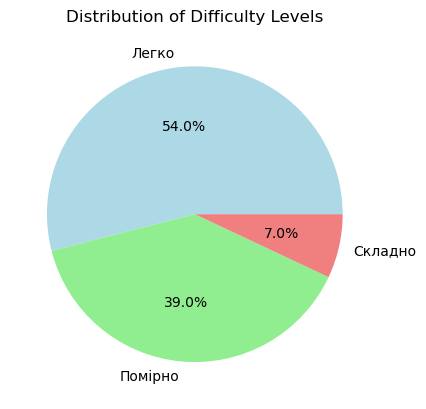

In [38]:
# Count the occurrences of each difficulty type
difficulty_counts = recipes_df['Складність'].value_counts()

# Plot a pie chart
plt.pie(difficulty_counts, labels=difficulty_counts.index, autopct='%1.1f%%', colors=['lightblue', 'lightgreen', 'lightcoral'])

# Add title
plt.title('Distribution of Difficulty Levels')

# Show the plot
plt.show()

In [39]:
pd.json_normalize(recipes_df.explode('Інгредієнти')['Інгредієнти']).shape

(1772, 4)

In [26]:
flatten_df = recipes_df.explode('Інгредієнти', ignore_index=True).join(pd.json_normalize(recipes_df.explode('Інгредієнти')['Інгредієнти']))

In [64]:
flatten_df = flatten_df[flatten_df['інгредієнт'].notna()]

In [27]:
del flatten_df['Інгредієнти']

In [28]:
# flatten_df

In [29]:
for i in sorted(flatten_df[flatten_df['інгредієнт'].notna()]['інгредієнт'].unique()):
    print(i)

(1 паковання) салату латук
(1 ст. л.) американської гірчиці
(1 шт.) солодкого перцю
(1 шт.) цибулі
(100 г) борошна
(3 ст. л.) олії для смаження
(3 ст.л.) олії
(4 ст.л.) апельсинового лікеру
(4,5 ст.л.) олії
(60 мл) вершків, жирністю 33 %
(половина качана) пекінської капусти
(приблизно 3 шт.) кисло-солодких яблук
(приблизно одна банка 3 л) квашених огірків
або 20 г вершкового масла для підготовки форми
авокадо
айви
американської гірчиці
апельсин
апельсин (+цедра від нього)
апельсин (цедра і сік)
апельсини
апельсинових скоринок (або 8 апельсинів, вагою приблизно по 235 г)
апельсинового соку
ароматної олії
багет
банка згущеного молока
банка тунця консервованого тунця
батат (приблизно 580 г)
бейбі шпинату
бекону
бланко текіли
борошна
борошна +20 г для підпилу
борошна +25 г на підпил
борошна +50 г на підпил
борошна всипте
борошна для підпилу
борошна на припорошення робочої поверхні
борошна на підпил
борошна на підпил робочої поверхні
бренді
бринзи
броколі
бульйону
буряк
буряків середнього р

In [42]:
flatten_df.head(1000)

Рецепт  \
0                      Нова ідея класичного салату. Салат з пекінської капусти з огірками і помідорами   
1                      Нова ідея класичного салату. Салат з пекінської капусти з огірками і помідорами   
2                      Нова ідея класичного салату. Салат з пекінської капусти з огірками і помідорами   
3                      Нова ідея класичного салату. Салат з пекінської капусти з огірками і помідорами   
4                      Нова ідея класичного салату. Салат з пекінської капусти з огірками і помідорами   
5                      Нова ідея класичного салату. Салат з пекінської капусти з огірками і помідорами   
6                                        Салат з пекінської капусти та сухариків від Євгена Клопотенка   
7                                        Салат з пекінської капусти та сухариків від Євгена Клопотенка   
8                                        Салат з пекінської капусти та сухариків від Євгена Клопотенка   
9                                        Салат з пекінської капусти та сухариків від Євгена Клопотенка   
10                                       Салат з пекінської капусти та сухариків від Євгена Клопотенка   
11                                       Салат з пекінської капусти та сухариків від Євгена Клопотенка   
12                                       Салат з пекінської капусти та сухариків від Євгена Клопотенка   
13                                       Салат з пекінської капусти та сухариків від Євгена Клопотенка   
14                                           У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
15                                           У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
16                                           У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
17                                           У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
18                                           У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
19                                           У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
20                                           У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
21                                           У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
22                                           У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
23                                           У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
24                                           У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
25                                           Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
26                                           Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
27                                           Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
28                                           Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
29                                           Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
30                                           Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
31                                           Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
32                                           Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
33                                           Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
34                                           Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
35                                           Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
36                                           Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
37                                         Сирники з яблуками та кор

In [67]:
flatten_df[flatten_df['інгредієнт'].str.contains("томат")]['інгредієнт'].unique()

array(['томати', 'томатної пасти', 'томатів пелаті',
       'томатів пелаті без рідини (баночка на 400 г)',
       'несоленого томатного соку', 'томатів чері',
       'домашнього томатного соку (або соусу)', 'томат', 'томати паста',
       'томати чері (або 1 середній помідор)', 'томатного соку'],
      dtype=object)

In [83]:
unified_ingridients = {
    "томатної пасти": "томатна паста",
    "томатів пелаті": "томати пелаті",
    "томатів пелаті без рідини (баночка на 400 г)": "томати пелаті",
    "несоленого томатного соку": "томатний сік",
    "томатів чері": "томати",
    "домашнього томатного соку (або соусу)": "томатний сік",
    "томат": "томати",
    "томати паста": "томатна паста",
    "томати чері (або 1 середній помідор)": "томати",
    "томатного соку": "томатний сік",

    "(1 паковання) салату латук": "салат",
    "(1 ст. л.) американської гірчиці": "американська гірчиця",
    "(1 шт.) солодкого перцю": "солодкий перець",
    "(1 шт.) цибулі": "цибуля",
    "(100 г) борошна": "борошно",
    "(3 ст. л.) олії для смаження": "олія",
    "(3 ст.л.) олії": "олія",
    "(4 ст.л.) апельсинового лікеру": "апельсиновий лікер",
    "(4,5 ст.л.) олії": "олія",
    "(60 мл) вершків, жирністю 33 %": "вершки",
    "(половина качана) пекінської капусти": "пекінська капуста",
    "(приблизно 3 шт.) кисло-солодких яблук": "яблука",
    "(приблизно одна банка 3 л) квашених огірків": "квашені огірки",
    "або 20 г вершкового масла для підготовки форми": "масло",
    "айви": "айва",
    "американської гірчиці": "американська гірчиця",
    "апельсин": "апельсини",
    "апельсин (+цедра від нього)": "апельсини",
    "апельсин (цедра і сік)": "апельсини",
    "апельсинових скоринок (або 8 апельсинів, вагою приблизно по 235 г)": "апельсини",
    "апельсинового соку": "апельсиновий сік",
    "ароматної олії": "олія",
    "банка згущеного молока": "згущене молоко",
    "банка тунця консервованого тунця": "консервований тунець",
    "батат (приблизно 580 г)": "батат",
    "бейбі шпинату": "шпинат",
    "бекону": "бекон",
    "бланко текіли": "текіла",
    "борошна": "борошно",
    "борошна +20 г для підпилу": "борошно",
    "борошна +25 г на підпил": "борошно",
    "борошна +50 г на підпил": "борошно",
    "борошна всипте": "борошно",
    "борошна для підпилу": "борошно",
    "борошна на припорошення робочої поверхні": "борошно",
    "борошна на підпил": "борошно",
    "борошна на підпил робочої поверхні": "борошно",
    "бринзи": "бринза",
    "бульйону": "бульйон",
    "буряків середнього розміру": "буряк",
    "бутони гвоздики": "гвоздика",
    "біла цибулина": "цибуля",
    "білих сухих грибів": "гриби",
    "білки": "яйця",
    "білого вершкового хріну": "хрін",
    "білого вина": "біле вино",
    "білого винного оцту": "оцет",
    "білого сухого вина": "біле вино",
    "білого хрону": "хрін",
    "білого хріну": "хрін",
    "білокачанної капусти": "капуста",
    "білої квасолі": "квасоля",
    "білої цибулини": "цибуля",
    "ванільного цукру": "ванільний цукор",
    "ванільного цукру (за бажанням - з кардамоном)": "ванільний цукор",
    "варення з троянд": "трояндове варення",
    "вареної згущівки": "згущене молоко",
    "велика морква": "морква",
    "велика морквина (приблизно 150 г)": "морква",
    "велика ріпчаста цибуля": "цибуля",
    "велика цибулина": "цибуля",
    "велика цибулина (приблизно 100 г)": "цибуля",
    "великих апельсини": "апельсини",
    "великих яблук": "яблука",
    "великих яйця": "яйця",
    "великі картоплини (по 100-120 г)": "картопля",
    "великі яйця": "яйця",
    "вершкового масла": "масло",
    "вершкового масла (+20 г для змащення форм)": "масло",
    "вершкового масла (на Щедру кутю)": "масло",
    "вершкового масла (розм`якшеного)": "масло",
    "вершкового масла (топленого)": "масло",
    "вершкового масла 82,5%": "масло",
    "вершкового масла для змащування форми": "масло",
    "вершкового масла для подачі": "масло",
    "вершкового масла кімнатної температури": "масло",
    "вершкового хріну": "хрін",
    "вершків": "вершки",
    "вершків 20%": "вершки",
    "вершків 33%": "вершки",
    "вершків 33% (холодних)": "вершки",
    "вершків жирністю 20 %": "вершки",
    "вершків жирністю 20%": "вершки",
    "вершків жирністю 33%": "вершки",
    "вершків, жирністю 33 %": "вершки",
    "вершків, жирністю 33%": "вершки",
    "винного оцту": "оцет",
    "вишні": "вишня",
    "води": "вода",
    "води або молока": "вода",
    "води для борошна": "вода",
    "води для замочування желатину": "вода",
    "води кімнатної температури": "вода",
    "води чи яблучного соку": "вода",
    "волоських горіхів": "волоські горіхи",
    "волоських горіхів (крупно поламаних)": "волоські горіхи",
    "вустерського соусу": "вустерський соус",
    "вівсяних пластівців (мелених або цілих)": "вівсяні пластівці",
    "вівсяних пластівців дрібного помолу": "вівсяні пластівці",
    "відварених креветок": "креветки",
    "відварених яйця": "яйця",
    "відварених яєчних жовтки": "яйця",
    "відварені картоплини (приблизно 200 г)": "картопля",
    "в’яленої вишні": "в’ялена вишня",
    "гарбуза": "гарбуз",
    "гарбузового насіння": "гарбузове насіння",
    "гарячої води": "вода",
    "головка часнику": "часник",
    "головки часнику": "часник",
    "голівок часнику": "часник",
    "горошин духмяного перцю": "духмяний перець",
    "горошин перцю": "перець",
    "горошин чорного перцю": "перець",
    "горошини духмяного перцю": "духмяний перець",
    "горошини чорного перцю": "перець",
    "горошки духмяного перцю": "духмяний перець",
    "горошків духмяного перцю": "духмяний перець",
    "горілки": "горілка",
    "горіхів": "горіхи",
    "гострого кетчупу": "кетчуп",
    "гілочки кропу": "кріп",
    "гілочки кінзи": "кінза",
    "гілочки петрушки": "петрушка",
    "гілочки розмарину": "розмарин",
    "гілочки тим’яну": "тим’ян",
    "гілочки чебрецю": "чебрець",
    "гілочок кропу": "кріп",
    "гілочок петрушки": "петрушка",
    "гілочок петрушки (для подачі)": "петрушка",
    "гілочок петрушки для подачі (за бажанням)": "петрушка",
    "гілочок чебрецю": "чебрець",
    "гірчиці": "гірчиця",
    "домашнього майонезу": "майонез",
    "домашньої ковбаси": "ковбаса",
    "домашньої ковбаски": "ковбаса",
    "домашня курка (приблизно 1,5 кг)": "курка",
    "домашній півень (2-2,5 кг)": "півень",
    "дрібка меленого мускатного горіха": "мускатний горіх",
    "дрібка солі": "сіль",
    "дрібно посіченого кропу": "кріп",
    "дрібної морської солі": "морська сіль",
    "діжонської гірчиці": "діжонська гірчиця",
    "еспресо чи молока": "еспресо",
    "желатину": "желатин",
    "желатину (220 bloom)": "желатин",
    "желатину (порошок)": "желатин",
    "живих (пресованих) дріжджів": "дріжджі",
    "живих дріжджів": "дріжджі",
    "живих дріжджів «Духмяна Хата»": "дріжджі",
    "живих пресованих дріжджів": "дріжджі",
    "жирної сметани": "сметана",
    "жовтки": "яйця",
    "жовтків": "яйця",
    "жовток": "яйця",
    "жовток для змащування": "яйця",
    "журавлини (в`яленої)": "журавлина",
    "загущувача (для магазинної сметани)": "загущувач",
    "замороженого шпинату": "шпинат",
    "замороженої вишні без кісточки": "вишня",
    "заморожені скумбрії": "скумбрія",
    "запечений буряк": "буряк",
    "згущеного молока": "згущене молоко",
    "зеленого горошку": "горошок",
    "зеленої сочевиці": "сочевиця",
    "зубчик часнику": "часник",
    "зубчики часнику": "часник",
    "зубчиків часнику": "часник",
    "зубчиків часнику (+ 4 зубчики у воду)": "часник",
    "зіри": "зіра",
    "зірочки бодяну": "бодян",
    "кави": "кава",
    "какао-порошку": "какао-порошок",
    "канелоні (12 трубочок)": "канелоні",
    "канелоні (12 штук)": "канелоні",
    "капусти": "капуста",
    "капусти броколі": "броколі",
    "кардамону": "кардамон",
    "картоплин (приблизно 500 г)": "картопля",
    "картоплин невеликого розміру (приблизно 600 г)": "картопля",
    "картоплини": "картопля",
    "картоплини (250 г)": "картопля",
    "картоплини (400 г)": "картопля",
    "картоплини (приблизно 550 г)": "картопля",
    "картоплі": "картопля",
    "картоплі (приблизно 5-6 середніх овочів)": "картопля",
    "качан капусти (1-1,5 кг)": "капуста",
    "качка (приблизно 2 кг)": "качка",
    "квашеної капусти": "квашена капуста",
    "келиха льоду": "лід",
    "кетчупу": "кетчуп",
    "кефіру": "кефір",
    "кип'яченої води": "вода",
    "кисломолочного сиру": "кисломолочний сир",
    "кисломолочного сиру 9%": "кисломолочний сир",
    "кмину": "кмин",
    "консервованого тунця (1 банка)": "консервований тунець",
    "коньяку або бренді": "коньяк",
    "коньяку чи бренді": "коньяк",
    "коньяку, рому чи віскі": "коньяк",
    "коньяку, щоб підпалити готовий пудинг": "коньяк",
    "копчених свинячих ребер": "ребра",
    "копченої буженини": "буженина",
    "копченої груші": "груша",
    "копченої паприки": "паприка",
    "кореня селери": "селера",
    "кориці": "кориця",
    "коричневого цукру": "цукор",
    "короп (1-1,5 кг)": "короп",
    "коріандру": "коріандр",
    "коріандру в зернах": "коріандр",
    "креветок": "креветки",
    "крекера грехема": "крекер",
    "крем-сиру": "крем-сир",
    "крем-сиру Філадельфія": "крем-сир",
    "крилець": "крилця",
    "кропу": "кріп",
    "крохмалу + 50 г для подачі": "крохмал",
    "крохмалю": "крохмал",
    "крупної морської солі": "морська сіль",
    "кріпленого вина": "вино",
    "кукурудзяного борошна": "борошно",
    "кукурудзяного крохмалю": "крохмал",
    "кукурудзяної крупи": "кукурудзяна крупа",
    "кураги": "курага",
    "курка (вагою 1,5-1,6 кг)": "курка",
    "курка, вагою 2-2,2 кг": "курка",
    "куряче філе (приблизно 300 г)": "куряче філе",
    "курячих гомілок": "курячі гомілки",
    "курячих крилець": "курячі крильця",
    "курячих сердець": "курячі сердечка",
    "курячих стегна": "курячі стегна",
    "курячих шлунків": " курячі шлунки",
    "курячого бульйону": "курячий бульйон",
    "курячого фаршу": "курячий фарш",
    "курячого філе": "куряче філе",
    "курячого філе стегна": "куряче філе стегна",
    "курячої печінки": "куряча печінка",
    "кускусу": "кускус",
    "кільки": "кілька",
    "лаваша": "лаваш",
    "лавровий листок": "лавровий лист",
    "лаврових листи": "лавровий лист",
    "лаврових листки": "лавровий лист",
    "лаврових листочки": "лавровий лист",
    "лаврові листки": "лавровий лист",
    "лайми": "лайм",
    "лимон (цедра та сік)": "лимон",
    "лимона": "лимон",
    "лимони": "лимон",
    "лимонного соку": "лимон",
    "листкового дріжджового тіста": "листкове дріжджове тісто",
    "листів лаваша": "лаваш",
    "лляної олії (для змащення вареників)": "олія",
    "лісових горіхів (або будь-яких за смаком)": "лісові горіхи",
    "ліщини": "ліщина",
    "м свинячої оболонки": "свиняча оболонка",
    "м'якого вершкового масла": "масло",
    "м'яса (свинина антрекот)": "свинина антрекот",
    "мʼякого вершкового масла": "масло",
    "майорану": "майоран",
    "маку": "мак",
    "маленька цибулина (60 г)": "цибуля",
    "малинового варення": "варення",
    "мандарини": "мандарин",
    "манки": "манка",
    "манної крупи": "манка",
    "масла": "масло",
    "масла для змащування": "масло",
    "медового лікеру": "лікер",
    "меду": "мед",
    "меду для подачі": "мед",
    "меленого кардамону": "кардамон",
    "меленого коріандру": "коріандр",
    "меленого мускатного горіха": "мускатний горіх",
    "меленого перцю чилі": "перець чилі",
    "меленої кориці": "кориця",
    "меленої паприки": "паприка",
    "меленої солодкої паприки": "паприка",
    "мигдалю": "мигдаль",
    "молока": "молоко",
    "молока кімнатної температури": "молоко",
    "молока  2,5%": "молоко",
    "моркви": "морква",
    "морквина": "морква",
    "морквина (приблизно 145 г)": "морква",
    "морквини": "морква",
    "морквини (приблизно 30 г)": "морква",
    "мороженої полуниці": "полуниця",
    "моцарели": "моцарела",
    "мускатного горіха": "мускатний горіх",
    "мідій": "мідії",
    "міксу салату": "салат",
    "міксу салатів": "салат",
    "мінеральної води": "мінеральна вода",
    "міріна (якщо немає, замініть 1 ст. л. рідкого меду)": "міріна",
    "м’якого вершкового масла": "масло",
    "м’якого масла": "масло",
    "м’якого сиру": "сир",
    "невелика цибуля (приблизно 100 г)": "цибуля",
    "овочевого бульйону (або води)": "овочевий бульйон",
    "окропу": "вода",
    "оливкової олії": "оливкова олія",
    "олії": "олія",
    "олії (для засмажки)": "олія",
    "олії (для фритюру)": "олія",
    "олії для змащування форми": "олія",
    "олії для смаження": "олія",
    "олії для смаження\\фритюру": "олія",
    "олії для смажіння": "олія",
    "олії чи смальцю": "олія",
    "оселедцю": "оселедець",
    "оселедця": "оселедець",
    "оцту": "оцет",
    "оцту або лимонного соку": "оцет",
    "очищеного гарбуза (300 г неочищеного)": "гарбуз",
    "паковання (500 г) курячого фаршу “Соковитий” від ТМ “Наша Ряба”": "курячий фарш",
    "паковання (65 г) бейбі шпинату": "шпинат",
    "паковання курячих гомілок \"Наша Ряба\" (7 шт.)": "курячі гомілки",
    "пакування свіжого шпинату": "шпинат",
    "пакування сиру “Старий Голландець” від ТМ “Комо”": "сир",
    "палочки кориці": "кориця",
    "панірувальних сухарів": "панірувальні сухарі",
    "паприки": "паприка",
    "пармезану": "пармезан",
    "пармезану для подачі": "пармезан",
    "пасти пене": "паста",
    "пекінської капусти (половина качана)": "пекінська капуста",
    "пекінської капусту": "пекінська капуста",
    "перлової крупи": "перловка",
    "перцю": "перець",
    "перці білозірка (або солодких жовтих)": "солодкий перець",
    "печериць": "печериці",
    "печива савоярді": "савоярді",
    "питного йогурту, жирністю 1,6%": "йогурт",
    "подрібненої петрушки (свіжої)": "петрушка",
    "полуниці": "полуниця",
    "помідорів чері": "томати",
    "порції локшини для рамена": "локшина",
    "почищеного гарбуза": "гарбуз",
    "пресованих (живих) дріжджів": "дріжджі",
    "пресованих дріжджів": "дріжджі",
    "пресованих дріжджів \"Духмяна Хата\"": "дріжджі",
    "приправи для риби": "приправа для риби",
    "просіяного пшеничного борошна": "борошно",
    "просіяного цільнозернового борошна+10 г для посипки": "борошно",
    "пучка кропу": "кріп",
    "пучка кінзи": "кінза",
    "пучок зеленої цибулі": "цибуля",
    "пучок кінзи": "кінза",
    "пучок петрушки": "петрушка",
    "пучок рамену": "рамен",
    "пшеничного борошна": "борошно",
    "пшеничного борошна (+ для посипання поверхні)": "борошно",
    "пшеничного борошна + 1 ст. л. для формування": "борошно",
    "пшеничного борошна + 50 г для підпилу": "борошно",
    "пшеничного борошна на підпил": "борошно",
    "пшона": "пшоно",
    "підсмаженого насіння кунжуту": "насіння кунжуту",
    "пірїни зеленої цибулі": "цибуля",
    "рафінованої олії для смаження": "олія",
    "рафінованої соняшникової олії": "олія",
    "рикоти": "рікота",
    "рисового борошна": "борошно",
    "рису": "рис",
    "рису басматі": "рис",
    "родзинок": "родзинки",
    "розм'якшеного вершкового масла": "масло",
    "розм’якшеного вершкового масла": "масло",
    "розпушувача": "розпушувач",
    "розтопленого вершкового масла": "масло",
    "рому": "ром",
    "рому (темного)": "ром",
    "рому (чи коньяку)": "ром",
    "рослинної олії": "олія",
    "рослинної олії або вершкового масла": "олія",
    "рослинної олії для (змащування форми)": "олія",
    "рослинної олії для змащування пательні": "олія",
    "рослинної олії для змащування форми": "олія",
    "рослинної олії для підготовки форми": "олія",
    "руколи": "рукола",
    "ріпчаста цибулина": "цибуля",
    "ріпчаста цибуля": "цибуля",
    "с. (62 мл) оливкової олії першого віджиму": "оливкова олія",
    "сала": "сало",
    "салатного міксу": "салат",
    "свинини": "свинина",
    "свинини (биточна частина)": "свинина",
    "свинини (філейна чи спинна частина)": "філе свинини",
    "свинини  (лопатка або задня частина)": "лопатка свинини",
    "свіжих огірків": "огірки",
    "свіжомеленого чорного перцю": "перець",
    "свіжомороженого шпинату або 150 г розмороженого": "шпинат",
    "селери": "селера",
    "середні картоплини": "картопля",
    "середніх буряки": "буряк",
    "сироватки": "сироватка",
    "сирої картоплі (або 400 г відвареної та розім’ятої)": "картопля",
    "сиру": "сир",
    "сиру «Голдер» від КОМО": "сир",
    "сиру дорблю": "дорблю",
    "сиру маскарпоне": "маскарпоне",
    "сиру рикота": "рікота",
    "сиру фета": "фета",
    "скибки білого хліба": "хліб",
    "скибки тостового хліба": "хліб",
    "скибок хліба": "хліб",
    "склянка цукрової пудри": "цукрова пудра",
    "склянки води": "вода",
    "слабосоленого лосося": "слабосолений лосось",
    "слабосоленого лосося “гравлакс”": "слабосолений лосось",
    "см кореня імбиру": "імбир",
    "смаженого мигдалю": "мигдаль",
    "сметани": "сметана",
    "сметани (для подачі)": "сметана",
    "сметани 20% чи більше": "сметана",
    "сметани, жирністю 20 %": "сметана",
    "соди": "сода",
    "соку лимона": "лимон",
    "солодкої гірчиці": "гірчиця",
    "солоні огірки": "солоні огірки",
    "солі": "сіль",
    "солі (в сам паштет)": "сіль",
    "солі для варіння субпродуктів": "сіль",
    "солі для гарбуза": "сіль",
    "солі для курки": "сіль",
    "солі для соусу": "сіль",
    "соняшникового насіння": "соняшникове насіння",
    "соняшникової олії": "олія",
    "соняшникової олії (для змащування форми)": "олія",
    "соняшникової олії (для пісної куті)": "олія",
    "соняшникової олії (для смаження)": "олія",
    "соняшникової олії для фритюру": "олія",
    "соусу барбекю": "соус барбекю",
    "соєвого соусу": "соєвий соус",
    "соєвого соусу (за бажанням)": "соєвий соус",
    "ст. л манної крупи": "манка",
    "ст. л панірувальних сухарів": "панірувальні сухарі",
    "ст. л.рослинної олії": "олія",
    "ст.л олії": "соєвий соус",
    "стебло селери (приблизно 70 г)": "селера",

    "столові ложки (60 мл) вершків, жирністю 33 %": "вершки",
    "суміші приправ для плову": "приправа для плову",
    "суміші спецій для курки": "спеції для курки",
    "сухарів": "сухарі",
    "сухих дріжджів": "дріжджі",
    "сухих дріжджів або 20 г живих": "дріжджі",
    "сухого часнику": "часник",
    "сухофруктів (сушена журавлина, родзинки, курага)": "сухофрукти",
    "сушених пластівців чилі": "чилі",
    "сушеного нуту": "нут",
    "сушеного часнику": "часник",
    "сушеної журавлини": "журавлина",
    "твердого сиру": "сир",
    "темного какао": "какао-порошок",
    "темного какао-порошку": "какао-порошок",
    "темного пива": "пиво",
    "темного соєвого соусу": "соєвий соус",
    "темного соєвого соусу (можна світлий)": "соєвий соус",
    "темного шоколаду": "шоколад",
    "теплого кефіру": "кефір",
    "теплого молока": "молоко",
    "теплої води": "вода",
    "тертого пармезану для подачі": "пармезан",
    "трави зубрівки": "зубрівка",
    "трикутник сиру Dorblu Käserei Champignon (100 г)": "сир",
    "тростинного цукру": "цукор",
    "тіста філо (7 листів)": "тісто філо",
    "фаршу": "фарш",
    "фети": "фета",
    "французька булка": "французька булка",
    "французької гірчиці в зернах": "французька гірчиця",
    "філе курячого стегна": "філе курячого стегна",
    "філе лосося": "лосось",
    "філе оселедця": "оселедець",
    "філе хека або минтая (або 1 кг замороженого філе)": "хек",
    "фініків": "фініки",
    "холодних вершків": "вершки",
    "холодної води": "вода",
    "цибулина": "цибуля",
    "цибулини": "цибуля",
    "цибулини (175 г)": "цибуля",
    "цибулини (для засмажки)": "цибуля",
    "цибулини (приблизно 220 г)": "цибуля",
    "цукатів": "цукати",
    "цукрового печива": "цукрове печиво",
    "цукрового сиропу": "цукровий сироп",
    "цукрової пудри": "цукрова пудра",
    "цукрової пудри (і додатково 1 ст. л. для посипання)": "цукрова пудра",
    "цукрової пудри + 50 г для подачі": "цукрова пудра",
    "цукрової пудри для подачі": "цукрова пудра",
    "цукру": "цукор",
    "цукру (3 якщо гарбуз не солодкий)": "цукор",
    "цукру чи меду": "цукор",
    "ціла курка (приблизно 2 кг)": "курка",
    "цільнозернового борошна": "борошно",
    "ч.л меленого кмину": "кмин",
    "ч.л меленого коріандру": "коріандр",
    "чебрецю": "чебрець",
    "червона цибулина": "цибуля",
    "червоного барвника на гелевій основі": "червоний барвник",
    "червоного винного оцту": "оцет",
    "червоного перцю пластівцями": "перець",
    "червоного сухого вина": "червоне вино",
    "червоної консервованої квасолі": "квасоля",
    "чорного меленого перцю": "перець",
    "чорного перцю": "перець",
    "чорного перцю горошком (приблизно 7-10 шт.)": "перець",
    "чорного шоколаду (2 плитки)": "шоколад",
    "чорносливу": "чорнослив",
    "шматків житнього хліба": "хліб",
    "шматочків багета": "багет",
    "шніту або зеленої цибулі (лише зеленої частини)": "цибуля",
    "шоколаду": "шоколад",
    "шоколаду (половина плитки)": "шоколад",
    "шоколаду для посипки": "шоколад",
    "шпинату": "шпинат",
    "шт. (400 г) буряків": "буряк",
    "шт. (400 г) картоплі": "картопля",
    "шт. (приблизно 635 г) батату": "батат",
    "шт. (приблизно 675 г) батату": "батат",
    "шт. блакитного хека": "хек",
    "шт. гвоздики": "гвоздика",
    "шт. круглого лаваша": "лаваш",
    "шт. чорносливу": "чорнослив",
    "яблук": "яблука",
    "яблука (приблизно 360 г)": "яблука",
    "яблука (приблизно 700 г)": "яблука",
    "яблуко": "яблука",
    "яблучного оцту": "оцет",
    "яблучного пюре": "яблучне пюре",
    "яблучного соку": "яблучний сік",
    "яйце": "яйця",
    "яйце для змащування": "яйця",
    "яйця (кімнатної температури)": "яйця",
    "яйця (сирих)": "яйця",
    "яйця кімнатної температури": "яйця",
    "яловичини": "яловичина",
    "яловичого фаршу": "яловичий фарш",
    "яловичої вирізки": "яловича вирізка",
    "яєць": "яйця",
    "яєць розміру С1": "яйця",
    "яєчних жовтки": "яйця",
    "імбиру": "імбир",
    "індичого філе": "індиче філе",
    "італійських трав": "італійські трави"
}

In [84]:
flatten_df['уніфікований інгредієнт'] = flatten_df['інгредієнт'].apply(lambda x: unified_ingridients.get(x,x))

/var/folders/15/ks9q9zp55y99s4lt86203cn00000gn/T/ipykernel_16766/2819029999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flatten_df['уніфікований інгредієнт'] = flatten_df['інгредієнт'].apply(lambda x: unified_ingridients.get(x,x))


In [88]:
flatten_df

Рецепт  \
0                       Нова ідея класичного салату. Салат з пекінської капусти з огірками і помідорами   
1                       Нова ідея класичного салату. Салат з пекінської капусти з огірками і помідорами   
2                       Нова ідея класичного салату. Салат з пекінської капусти з огірками і помідорами   
3                       Нова ідея класичного салату. Салат з пекінської капусти з огірками і помідорами   
4                       Нова ідея класичного салату. Салат з пекінської капусти з огірками і помідорами   
5                       Нова ідея класичного салату. Салат з пекінської капусти з огірками і помідорами   
6                                         Салат з пекінської капусти та сухариків від Євгена Клопотенка   
7                                         Салат з пекінської капусти та сухариків від Євгена Клопотенка   
9                                         Салат з пекінської капусти та сухариків від Євгена Клопотенка   
10                                        Салат з пекінської капусти та сухариків від Євгена Клопотенка   
11                                        Салат з пекінської капусти та сухариків від Євгена Клопотенка   
12                                        Салат з пекінської капусти та сухариків від Євгена Клопотенка   
13                                        Салат з пекінської капусти та сухариків від Євгена Клопотенка   
14                                            У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
15                                            У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
16                                            У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
17                                            У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
18                                            У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
19                                            У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
20                                            У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
21                                            У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
22                                            У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
23                                            У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
24                                            У вершковому соусі. Равіолі з сиром від Євгена Клопотенка   
25                                            Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
26                                            Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
27                                            Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
28                                            Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
29                                            Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
30                                            Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
31                                            Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
32                                            Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
33                                            Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
34                                            Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
35                                            Гарбузовий торт зі сметанним кремом від Євгена Клопотенка   
37                                          Сирники з яблуками та корицею за рецептом Євгена Клопотенка   
38                                          Сирники з яблуками та корицею за рецептом Євгена Клопотенка   
39                             

In [90]:
# Group by Cuisine and count ingredient frequencies
ingredient_frequencies = flatten_df.groupby('Кухня')['уніфікований інгредієнт'].value_counts()

# Find the most frequently used ingredients across different cuisines
top_ingredients_per_cuisine = ingredient_frequencies.groupby(level=0).nlargest(5).reset_index(level=0, drop=True)

print(top_ingredients_per_cuisine)


Кухня                        уніфікований інгредієнт
Європейська                  цукор                      51
                             сіль                       50
                             яйця                       46
                             масло                      43
                             борошно                    40
Італійська                   сіль                       20
                             борошно                    11
                             яйця                       11
                             олія                       10
                             цукор                       9
Автентична українська кухня  борошно                    19
                             сіль                       18
                             олія                       17
                             вода                       13
                             цукор                      12
Американська                 масло                      12
   

In [97]:
flatten_df.to_csv(r"Klopotenkorecipes.csv", index=False)

In [33]:
# Sample DataFrame
new_data = {
    'Кухня': ['Європейська', 'Українська', 'Італійська',
       'Автентична українська кухня', 'Американська', 'Арабська',
       'Східна', 'Кримськотатарська', 'Мексиканська', 'Японська',
       'Французька'],
    'Інгредієнти': [
        [{'інгредієнт': 'пекінської капусту', 'одиниця вимірювання': 'кг', 'кількість': 0.35, 'raw': '350 г пекінської капусту'}, {'інгредієнт': 'томати', 'одиниця вимірювання': 'штука', 'кількість': 2.0, 'raw': '2 томати'}, {'інгредієнт': 'огірок', 'одиниця вимірювання': 'штука', 'кількість': 1.0, 'raw': '1 огірок'}, {'інгредієнт': 'пучок кінзи', 'одиниця вимірювання': 'штука', 'кількість': 1.0, 'raw': '1 пучок кінзи'}, {'інгредієнт': 'ароматної олії', 'одиниця вимірювання': 'ст.л.', 'кількість': 3.0, 'raw': '3 ст.л. ароматної олії'}, {'інгредієнт': 'солі', 'одиниця вимірювання': 'ч.л.', 'кількість': 0.33, 'raw': '⅓ ч.л. солі'}]
    ]
}

# Create a list to store individual ingredient DataFrames
ingredient_dfs = []

# Iterate over each row in the sample DataFrame
for index, row in enumerate(new_data['Інгредієнти']):
    # Extract ingredient names for the current row
    ingredient_cuisine_list = [ingredient['інгредієнт'] for ingredient in row]
    # Create a DataFrame for the current row
    ingredient_cuisine_df = pd.DataFrame({'Інгредієнти': ingredient_cuisine_list})
    # Append the DataFrame to the list
    ingredient_dfs.append(ingredient_cuisine_df)

# Concatenate all ingredient DataFrames into a single DataFrame
new_df = pd.concat(ingredient_dfs, ignore_index=True)

print(new_df)

          Інгредієнти
0  пекінської капусту
1              томати
2              огірок
3         пучок кінзи
4      ароматної олії
5                солі


In [34]:
# Sample DataFrame
new_data = {
    'Кухня': ['Європейська', 'Українська', 'Італійська',
       'Автентична українська кухня', 'Американська', 'Арабська',
       'Східна', 'Кримськотатарська', 'Мексиканська', 'Японська',
       'Французька'],
    'Інгредієнти': [
        [{'інгредієнт': 'пекінської капусту', 'одиниця вимірювання': 'кг', 'кількість': 0.35, 'raw': '350 г пекінської капусту'}, {'інгредієнт': 'томати', 'одиниця вимірювання': 'штука', 'кількість': 2.0, 'raw': '2 томати'}, {'інгредієнт': 'огірок', 'одиниця вимірювання': 'штука', 'кількість': 1.0, 'raw': '1 огірок'}, {'інгредієнт': 'пучок кінзи', 'одиниця вимірювання': 'штука', 'кількість': 1.0, 'raw': '1 пучок кінзи'}, {'інгредієнт': 'ароматної олії', 'одиниця вимірювання': 'ст.л.', 'кількість': 3.0, 'raw': '3 ст.л. ароматної олії'}, {'інгредієнт': 'солі', 'одиниця вимірювання': 'ч.л.', 'кількість': 0.33, 'raw': '⅓ ч.л. солі'}]
    ]
}

# Create a DataFrame to store the ingredients and their corresponding cuisine
new_ingredient_list = []
new_cuisine_list = []

# Iterate over each row in the sample DataFrame
for index, row in enumerate(new_data['Інгредієнти']):
    # Extract ingredient names and cuisine for the current row
    ingredient_cuisine_list = [ingredient['інгредієнт'] for ingredient in row]
    cuisine = new_data['Кухня'][index]
    # Extend the ingredient and cuisine lists
    new_ingredient_list.extend(ingredient_cuisine_list)
    new_cuisine_list.extend([cuisine] * len(ingredient_cuisine_list))

# Create a DataFrame with 'Кухня' and 'Інгредієнти' columns
new_df = pd.DataFrame({'Кухня': new_cuisine_list, 'Інгредієнти': new_ingredient_list})

print(new_df)

         Кухня         Інгредієнти
0  Європейська  пекінської капусту
1  Європейська              томати
2  Європейська              огірок
3  Європейська         пучок кінзи
4  Європейська      ароматної олії
5  Європейська                солі
